## Homework 5 - The eternal significance of publications and citations!
#### Group 18: Yousef Kanj (2113258), Simone Zagaria (2145389), Matteo Pazzini (1868953), Sai Swaroop Chittoor (1916247) 
_____

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import ijson
import time
from prettytable import PrettyTable 
import matplotlib.pyplot as plt
from collections import deque
from collections import *
from tqdm import tqdm
import re
import matplotlib.colors as mcolors
import itertools
import ipywidgets as widgets
from IPython.display import display, clear_output
start = time.process_time()

_____
## Exploratory data analysis 

Since the JSON file provided had a large number of fields, what we did was to read it line by line (using the ijson library), extracting only the columns of interest and appending them to a Pandas Dataframe. The Dataframe contained:

- *id*: the unique identifier for the paper
- *title*: the title of the paper
- *authors*: a list of dictionaries containing all the authors for the paper. Each dictionary contains:
    - *name*: the name of the author
    - *org*: the organization of the author
    - *id*: the for the author
- *year*: the year of publication of the paper
- *n_citation*: the number of citations received by the paper
- *doc_type*: the type of the document
- *references*: a list of ids for papers that are referenced by the current paper
- *doi*: the digital object identifier

Since some papers contained missing or undefined values, we used the 'get' method to handle these cases by providing default values or assigning NaN where appropriate

In [ ]:

papers = []

with open('dblp.v12.json', "rb") as file:
    for i, element in enumerate(ijson.items(file, "item")):

        # Extracting the most valuable data
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']
        paper['authors'] = element.get('authors',np.nan)
        paper['year'] = element.get('year', np.nan)
        paper['n_citation'] = element.get('n_citation', 0)
        paper['doc_type'] = element.get('doc_type', np.nan)
        paper['references'] = element.get('references', np.nan)
        paper['doi'] = f"https://doi.org/{element['doi']}" if 'doi' in element else np.nan
        papers.append(paper)
        if i%100000 ==0:
            print(f"{i}:{round((time.process_time() - start),2)}s ",end="") 
csvread = pd.DataFrame(papers)
first_10k_rows = csvread.sort_values(by="n_citation",ascending=False).iloc[:10000]
first_10k_rows.to_csv("first_10k_rows.csv")
first_10k_rows.head(10)


Followingly, the task is to create two subgraphs, a Citation graph and a Collaboration graph, considering only the top 10,000 papers with the highest number of citations. 

Thus, in the following code we constructed a subset of the Dataframe, containing only the top 10,000 papers with the highest number of citations:

In [42]:
first_10k_rows = pd.read_csv("first_10k_rows.csv")
first_10k_rows = first_10k_rows.drop(["Unnamed: 0", "doc_type", "doi"], axis =1)

def authors_to_dict(input_string): # This function converts the authors column to a clean dictionary with ID as key and name as value
    pattern = r"'name':\s*'([^']+)'.*?'id':\s*(\d+)(?:,.*?|})"
    matches = re.findall(pattern, input_string)

    result_dict = {int(id_): name for name, id_ in matches}

    return result_dict
first_10k_rows["references"] = first_10k_rows["references"].apply(lambda x: list(map(int, x.strip("[]").split(", "))) if type(x) != float else x)
first_10k_rows["authors"] = first_10k_rows["authors"].apply(authors_to_dict)

first_10k_rows.head(5)

id                                              title  \
0  2041404167           The Mathematical Theory of Communication   
1  1639032689  Genetic algorithms in search, optimization, an...   
2  2912565176                                         Fuzzy sets   
3  2151103935  Distinctive Image Features from Scale-Invarian...   
4  2911964244                                     Random Forests   

                             authors  year  n_citation  \
0      {2247248564: 'C. E. Shannon'}  1949       48327   
1  {2102678951: 'David E. Goldberg'}  1989       44175   
2     {2252586558: 'Lotfi A. Zadeh'}  1996       42437   
3      {2104328312: 'David G. Lowe'}  2004       35541   
4        {2569376642: 'Leo Breiman'}  2001       34741   

                                          references  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  [19720318, 1541642243, 1560959218, 1676552347,...  
4  [1507255258, 1580948147, 1605688901, 197584664...

_____


## 1. Creating our Graphs

The citation graph we created is unweighted and directed graph, where each of the top 10000 papers is treated as a node. An edge is formed from one node to another if the first paper made a reference to the second.

On the other hand, the collaboration graph we created is an undirected and weighted graph. It contains the authors of each of the 10000 papers as nodes, and an edge is formed if the two authors worked together. The weight of the edges always starts at 1 and increases by 1 for each work the two authors collaborated on.

In [8]:
def create_citations_graph(dataframe: pd.DataFrame):
    # Creating a graph
    citation_graph = nx.DiGraph()

    # Adding a node to the graph for each paper in the DataFrame
    citation_graph.add_nodes_from(dataframe['id'])

    # Adding directed edges based on citation relationships
    for _, row in dataframe.iterrows():
        paper_id = row['id']
        references = row['references']

        # Check if the references are not NaN and is a list
        if references is not np.nan and isinstance(references, list):
            # Adding edges for valid references
            links = [(paper_id, ref) for ref in references if citation_graph.has_node(ref)]
            citation_graph.add_edges_from(links)
    
    return citation_graph

def create_collaboration_graph(dataframe: pd.DataFrame):
    # Creating a graph
    collaboration_graph = nx.Graph()

    # Iterating through papers in the DataFrame
    for _, row in dataframe.iterrows():
        paper_id = row['id']
        authors = row['authors']

        # Convert authors to a list of IDs if it's a dictionary
        if authors is not np.nan and isinstance(authors, dict):
            author_ids = list(authors.keys())

            # Adding single authors as nodes
            if len(author_ids) == 1:
                author = author_ids[0]
                if not collaboration_graph.has_node(author):
                    collaboration_graph.add_node(author)

            # Adding edges for collaborations
            if len(author_ids) > 1:
                for i in range(len(author_ids)):
                    for j in range(i + 1, len(author_ids)):
                        author1 = author_ids[i]
                        author2 = author_ids[j]

                        # Increasing weight of existing edge or adding new edge
                        if author1 != author2: 
                            if collaboration_graph.has_edge(author1, author2):
                                # If the edge already exists, increase the weight by 1
                                collaboration_graph[author1][author2]['weight'] += 1
                                collaboration_graph[author1][author2]['capacity'] += 1
                                collaboration_graph[author1][author2]['paper_ids'].append(paper_id)

                            else:
                                # If the edge doesn't exist, create a new edge with weight 1
                                collaboration_graph.add_edge(author1, author2, weight=1, capacity =1, paper_ids=[paper_id])

    return collaboration_graph

In [10]:
citation_graph = create_citations_graph(first_10k_rows)
print(f"Our Citation graph has {citation_graph.number_of_nodes()} nodes, and {citation_graph.number_of_edges()} edges.")

collaboration_graph = create_collaboration_graph(first_10k_rows)
print(f"Our Collaboration graph has {collaboration_graph.number_of_nodes()} nodes, and {collaboration_graph.number_of_edges()} edges.")


Our Citation graph has 10000 nodes, and 52252 edges.
Our Collaboration graph has 21180 nodes, and 135500 edges.


_____

## 2. Controlling system


### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.

**Input:**
- The graph
- The name of the graph

**Output:**
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

In [8]:
def funct_1(graph,graph_name):

    if graph_name == "Citation Graph":
        
        # Results were displayed using python's PrettyTable
        citation_overview_table = PrettyTable()
        citation_overview_table.add_column("Graph type:", ["Number of Nodes", "Number of Edges", "Density", "Average Degree", "Sparse or Dense"])
        

        ncit_nodes = graph.number_of_nodes() #nodes
        ncit_edges = graph.number_of_edges() #edge
        cit_graph_density = ncit_edges/(ncit_nodes*(ncit_nodes-1)) # since the graph is directed we can compute the graph density using this formula

        max_theoretical_edges = int(ncit_nodes*(ncit_nodes-1)) # max edges for an undirected graph, to check if the graph is sparse
        nodeinfo = []
        indegreelist = []
        outdegreelist = []

        for node in graph:
            in_degree_node = graph.in_degree(node) 
            out_degree_node = graph.out_degree(node)
            total_degree_node =  graph.degree(node) #in_degree + out_degree
            indegreelist.append(in_degree_node)
            outdegreelist.append(out_degree_node)
            nodeinfo.append(total_degree_node)
        sum_deg = sum(nodeinfo) 
        
        p = np.percentile(nodeinfo, 95)  # return 95th percentile
        
        node_hubs = [(node,graph.degree(node)) for node in graph if graph.degree(node) > p]
        node_hubs.sort(key=lambda x: x[1])
        node_hubs=node_hubs[::-1]
        threshold = ncit_edges/max_theoretical_edges
        if threshold > 0.7:
            density = "Dense"
        else: 
            density = "Sparse"

        citation_overview_table.add_column("Citation Graph", [ncit_nodes, ncit_edges, cit_graph_density,sum_deg/ncit_nodes, density]) # here we continue filling in our tables
        
        citation_hub_table = PrettyTable(["Hubs (Top 5)", "Degree"])
        for hub in node_hubs[0:5]:
            citation_hub_table.add_row([hub[0], hub[1]])
        print(citation_overview_table)
        print(citation_hub_table)

        # we plot the number of citations given and number received versus the number of papers who achieved that

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        in_degrees = [graph.in_degree(node) for node in graph]
        axs[0].hist(in_degrees, bins=20, color='orchid')
        axs[0].set_title("Distribution of Citations Received within the Top 10k")
        axs[0].set_xlabel("Number of Citations Received")
        axs[0].set_ylabel("Number of Papers")
        axs[0].grid(True)

        out_degrees = [graph.out_degree(node) for node in graph]
        axs[1].hist(out_degrees, bins=20, color='steelblue')
        axs[1].set_title("Distribution of Given Citations within the Top 10k")
        axs[1].set_xlabel("Number of Citations Given")
        axs[1].set_ylabel("Number of Papers")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        

    if graph_name == "Collaboration Graph": 

        citation_overview_table = PrettyTable() # we again use prettytable
        citation_overview_table.add_column("Graph type:", ["Number of Nodes", "Number of Edges", "Density", "Average Degree", "Sparse or Dense"])
        
        ncoll_nodes = graph.number_of_nodes() #number nodes
        ncoll_edges = graph.number_of_edges() #number edges
        coll_graph_density = 2*ncoll_edges/(ncoll_nodes*(ncoll_nodes-1)) #since the graph is undirected we can compute the graph density using this formula
        
        max_theoretical_edges = int(ncoll_nodes*(ncoll_nodes-1)/2) #max edges for an undirected graph, to check if the grapgh is sparse
        nodeinfo = []
        for node in graph:
            node_degree = graph.degree(node)
            nodeinfo.append(node_degree)

        degree_sequence = sorted(nodeinfo, reverse=True) #list of degrees of nodes, to get the distribution we can use a Counter (how many times the degree appears)
        sum_deg = sum(degree_sequence) #Handshaking Lemma, so the sum of each degree is just 2*number of edges

        p = np.percentile(degree_sequence, 95)  # return 95th percentile
        node_hubs = [(node,graph.degree(node)) for node in graph if graph.degree(node) > p]
        node_hubs.sort(key=lambda x: x[1])
        node_hubs=node_hubs[::-1]
        threshold = ncoll_edges/max_theoretical_edges
        if threshold > 0.7:
            density = "Dense"
        else: density = "Sparse"

        # we continue filling in our graphs
        citation_overview_table.add_column("Collaboration Graph", [ncoll_nodes, ncoll_edges, coll_graph_density,sum_deg/ncoll_nodes, density])
        citation_hub_table = PrettyTable(["Hubs (Top 5)", "Degree"])
        for hub in node_hubs[0:5]:
            citation_hub_table.add_row([hub[0], hub[1]])
        print(citation_overview_table)
        print(citation_hub_table)
        
        # we plot the top 20 authors_ids vs the number of collaborations
        plt.figure()
        top_collaborations = sorted([(node, graph.degree(node)) for node in graph], key=lambda x: x[1], reverse=True)[:20]
        authors, collaborations = zip(*top_collaborations)
        plt.bar(np.arange(len(authors)), collaborations, color='red')
        plt.xticks(np.arange(len(authors)), authors, rotation='vertical')
        plt.title("Top 20 Authors by Number of Collaborations")
        plt.xlabel("Author ID")
        plt.ylabel("Number of Collaborations")
        plt.grid(True)
        plt.show()
        
    return 

+-----------------+-----------------------+
|   Graph type:   |     Citation Graph    |
+-----------------+-----------------------+
| Number of Nodes |         10000         |
| Number of Edges |         52252         |
|     Density     | 0.0005225722572257226 |
|  Average Degree |        10.4504        |
| Sparse or Dense |         Sparse        |
+-----------------+-----------------------+
+--------------+--------+
| Hubs (Top 5) | Degree |
+--------------+--------+
|  2076063813  |  152   |
|  2151103935  |  144   |
|  1791587663  |  122   |
|  2156909104  |  120   |
|  1639032689  |  104   |
+--------------+--------+


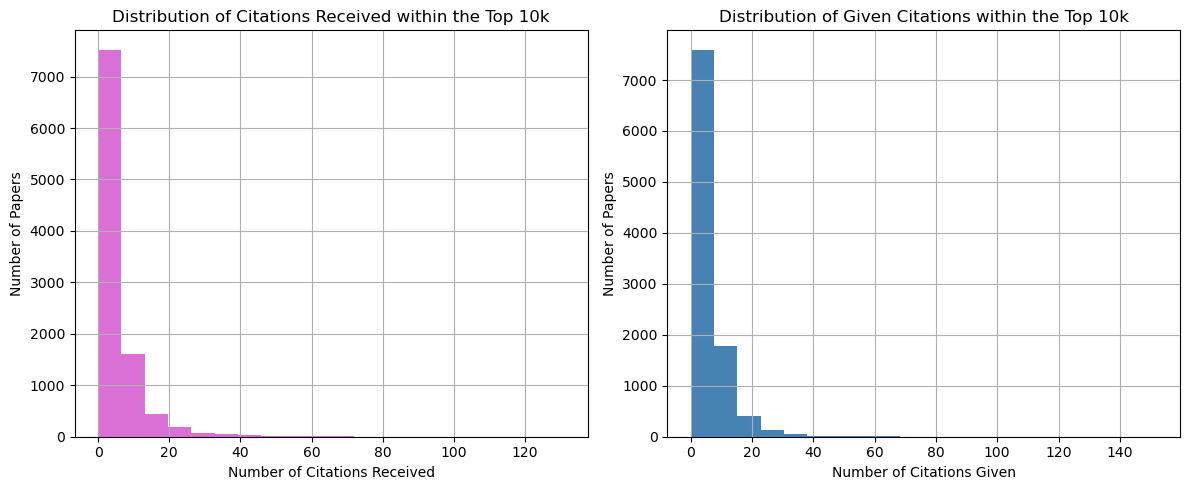

In [9]:
funct_1(citation_graph,"Citation Graph")

+-----------------+-----------------------+
|   Graph type:   |  Collaboration Graph  |
+-----------------+-----------------------+
| Number of Nodes |         21180         |
| Number of Edges |         135500        |
|     Density     | 0.0006041404082945847 |
|  Average Degree |   12.79508970727101   |
| Sparse or Dense |         Sparse        |
+-----------------+-----------------------+
+--------------+--------+
| Hubs (Top 5) | Degree |
+--------------+--------+
|  1973035492  |  346   |
|  332422508   |  325   |
|  2146468246  |  303   |
|  173839695   |  295   |
|  1976452423  |  283   |
+--------------+--------+


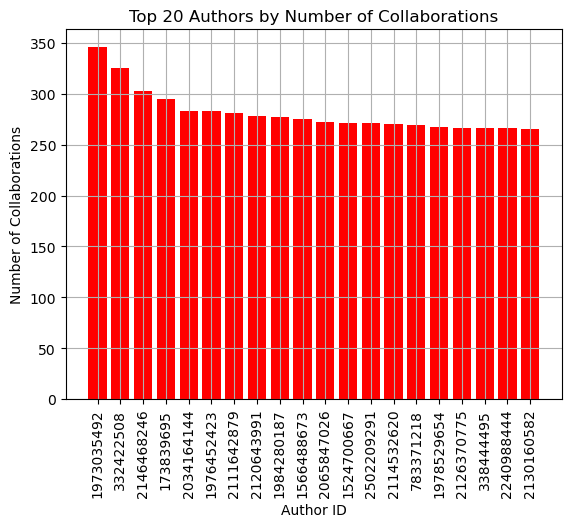

In [10]:
funct_1(collaboration_graph,"Collaboration Graph")

_____
### Functionality 2 - Nodes' contribution
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

**Input:**

- The graph
- A node of the graph (paper/author)
- The name of the graph

**Output:**

- The centrality of the node, calculated based on the following centrality measurements:
- Betweeness
- PageRank
- ClosenessCentrality
- DegreeCentrality

In [72]:
def funct_2(graph, select_node_id, graph_name):
    table = PrettyTable()                                                      
    table.field_names = ["Centrality Measure", "Top 5 Nodes and Values"]
    if select_node_id not in graph:
        print(f"Node {select_node_id} not found in the graph.")
        return

    # Check if the node is isolated
    if graph.degree(select_node_id) == 0:
        print(f"Node {select_node_id} is isolated (no connections).")
        return

    selected_node_subgraph = graph.subgraph(graph[select_node_id])

    def top_5_formatted(centrality_dict):
        top_5 = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:5]
        return ", ".join([f"{node}: {value:.3f}" for node, value in top_5])

    if graph_name == "Citation Graph":
        in_degree_centrality = nx.in_degree_centrality(selected_node_subgraph)
        table.add_row(["In-Degree Centrality", top_5_formatted(in_degree_centrality)])

        betweenness_centrality = nx.betweenness_centrality(selected_node_subgraph)
        table.add_row(["Betweenness Centrality", top_5_formatted(betweenness_centrality)])

        closeness_centrality = nx.closeness_centrality(selected_node_subgraph)
        table.add_row(["Closeness Centrality", top_5_formatted(closeness_centrality)])

        pagerank = nx.pagerank(selected_node_subgraph)
        table.add_row(["PageRank", top_5_formatted(pagerank)])

    elif graph_name == "Collaboration Graph":
        degree_centrality = nx.degree_centrality(selected_node_subgraph)
        table.add_row(["Degree Centrality", top_5_formatted(degree_centrality)])

        betweenness_centrality = nx.betweenness_centrality(selected_node_subgraph)
        table.add_row(["Betweenness Centrality", top_5_formatted(betweenness_centrality)])

        closeness_centrality = nx.closeness_centrality(selected_node_subgraph)
        table.add_row(["Closeness Centrality", top_5_formatted(closeness_centrality)])

        pagerank = nx.pagerank(selected_node_subgraph)
        table.add_row(["PageRank", top_5_formatted(pagerank)])

    print(table)
    return


In [73]:
funct_2(citation_graph,2020246210,"Citation Graph") 

+------------------------+-----------------------------------------------------------------------------------------------+
|   Centrality Measure   |                                     Top 5 Nodes and Values                                    |
+------------------------+-----------------------------------------------------------------------------------------------+
|  In-Degree Centrality  | 2165758113: 0.182, 2137983211: 0.182, 1971735090: 0.182, 2103496339: 0.091, 2041404167: 0.000 |
| Betweenness Centrality | 2103496339: 0.027, 2137983211: 0.018, 2165758113: 0.000, 2041404167: 0.000, 1994616650: 0.000 |
|  Closeness Centrality  | 2165758113: 0.208, 1971735090: 0.205, 2137983211: 0.182, 2103496339: 0.121, 2041404167: 0.000 |
|        PageRank        | 2103496339: 0.161, 2165758113: 0.148, 2137983211: 0.124, 1971735090: 0.124, 2041404167: 0.055 |
+------------------------+-----------------------------------------------------------------------------------------------+


In [74]:
funct_2(collaboration_graph,1973035492,"Collaboration Graph") 

+------------------------+-----------------------------------------------------------------------------------------------+
|   Centrality Measure   |                                     Top 5 Nodes and Values                                    |
+------------------------+-----------------------------------------------------------------------------------------------+
|   Degree Centrality    | 1524700667: 0.757, 2036498445: 0.748, 2131200026: 0.748, 1165226023: 0.748, 2670774312: 0.748 |
| Betweenness Centrality | 1524700667: 0.378, 2141862317: 0.133, 2120643991: 0.133, 2230831812: 0.102, 2068107358: 0.001 |
|  Closeness Centrality  | 1524700667: 0.804, 2036498445: 0.669, 2131200026: 0.669, 1165226023: 0.669, 2670774312: 0.669 |
|        PageRank        |  2146468246: 0.007, 173839695: 0.006, 2120643991: 0.006, 2133227394: 0.006, 2111642879: 0.006 |
+------------------------+-----------------------------------------------------------------------------------------------+


_____
### Functionality 3 - Shortest ordered walk


**Input** :
- The graph data
- A sequence of authors_a = [ a_1, a_2, ..., a_{n-1}, a_{n} ]
- N: denoting the top N authors whose data should be considered

**Output**:\
The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

Our approach to this problem will be implementing a breadth first search algorithm between each subsequent pair of authors in our list. This is the optimal technique in our opinion because, while this is a weighted graph, the weights don't signify distances, and we are looking for the fastest path.

Our algorithm essentially works with a queue where each element is a tuple of a node and the path to that node. First, we pop our stating point, and look for all of its neighbors. we keep track of neighbors we have seen by adding them to a set. If we haven't seen them before, we append them back to the queue with the path it took to get there. We then repeat this process for every node we popleft() from the queue, adding their neighbors back to the queue, until we reach our end node.

In [27]:
def bfs(start, end, graph):
    """""""""""""""""""""""""""""""""""""""""""""
    this function implements a breadth first
    search between two given nodes in our graph.
    """""""""""""""""""""""""""""""""""""""""""""
    if start == end:
        return [start]

    visited = set()                                          # To keep track of seen nodes
    queue = deque([(start, [start])])                        # Initialize our queue for the search

    while queue:
        current_node, path = queue.popleft()

        if current_node == end:                              # End our search if we reach the end point
            return path  

        for neighbor in graph.neighbors(current_node):       # Search for neighbors for each node
            if neighbor not in visited:
                visited.add(neighbor)  
                queue.append((neighbor, path + [neighbor]))  # Add to queue unseen nodes with their path

    print(f"No path exists connecting {start} and {end}" )
    return False

def funct_3(author_id_sequence = list, N = int, graph = collaboration_graph):
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    This function implements the bfs function between every two sequential 
    pairs in our author_id_sequence list and returns the joined path in the end.
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # First, a few assertions to ensure everything is working as needed

    assert N <= 21179, ("Please remember that there are 21179 nodes in total. N must be less than or equal.")
    assert len(author_id_sequence) >= 2, ("Please choose more than 2 authors.")
    
    # Second, we get the top N nodes by number of collaborations (sum of Weights of edges coming out of each node). 
    # We also include additional nodes just outside the top N but with the same weight to stay fair since weights are discreet.

    top_N_authors = {node: sum(data["weight"] for _,_,data in graph.edges(node, data = True)) for node in graph.nodes() }
    top_N_authors = sorted(top_N_authors.items(), key = lambda x: x[1], reverse=True)
    top_N_authors = [x for x in top_N_authors if x[1]>=top_N_authors[N][1]]
    top_N_author_ids = [author_id for author_id, _ in top_N_authors]
    for author_id in author_id_sequence:
        if author_id not in top_N_author_ids:
            raise AssertionError(f"Author ID [{author_id}] not in top {N} authors by collaborations.")
    smaller_graph = graph.subgraph(top_N_author_ids)   

    # Now that we have ensured that we can start, Our approach will be a breadth first search considering tHat our weights
    # don't signify distances, this way we can ensure finding the shortest path (lowest degree of separation) between any 
    # two authors.

    shortest_path =[author_id_sequence[0]]
    for i in range(len(author_id_sequence)-1):
        initial = author_id_sequence[i]
        final = author_id_sequence[i+1]
        current_path = bfs(initial, final, smaller_graph)
        if type(current_path) == str:
            solved = False
            print(current_path)
            if len(shortest_path) > 2 and len(author_id_sequence) >2:
                print(f"Our current shortest path is {shortest_path} of length {len(shortest_path)}.")
        else:
            solved = True
            shortest_path.extend(current_path[1:])

    if solved:
        nodetable = PrettyTable()
        nodetable.add_column("Node ID",shortest_path)
        print(f"Our shortest path is {shortest_path} of length {len(shortest_path)}.", )

        cut_subgraph = nx.subgraph(collaboration_graph, shortest_path)    
        labels = nx.get_edge_attributes(cut_subgraph,'weight') #weights, so that in the plot every edge has a different width

        path_edges = list(zip(shortest_path,shortest_path[1:])) #by zipping the shortest path we get a list of edges between the two nodes
        path_order = {t: i+1 for i, t in enumerate(path_edges)} #we create a dictionary with the following structure:
        #{(node1,node2): 1, (node2,node2):2...} with a sequential integer as value, which is the order of the walk

        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(cut_subgraph,k=0.5)
        nx.draw_networkx_nodes(cut_subgraph,pos,nodelist=shortest_path,node_color='lightblue')
        nx.draw_networkx_edges(cut_subgraph,pos,edgelist=labels.keys(),edge_color='b',width=list(labels.values())) #the width of the edge is linked to the weight
        nx.draw_networkx_edge_labels(cut_subgraph,pos,edge_labels=path_order,font_size=10,font_color='r') #we then use the path_order defined above as edge_label
        nx.draw_networkx_labels(cut_subgraph, pos, font_size=9)
        nx.draw_networkx_nodes(collaboration_graph, pos, nodelist=author_id_sequence, node_color="green",node_size=500) #color code every input node
        #the walk
        plt.axis('equal')
        plt.title("Fastest Path Across Authors using Breadth First Search")
        plt.show()


        idtable = PrettyTable()

        papers = []
        for i in range(len(shortest_path)-1):
            papers.append(collaboration_graph.get_edge_data(shortest_path[i], shortest_path[i+1])["paper_ids"][0])

        titles = []
        for paper in papers:
            titles.append(first_10k_rows[first_10k_rows["id"] == paper]["title"].values[0])   


        print(f"The shortest path between these authors is the following papers:")    
        print("")
        idtable.add_column("Paper ID",papers)
        idtable.add_column("Titles",titles)

        print(idtable) 
        

      

Our shortest path is [2097546270, 2485834696, 2308824398, 2102002796, 2473549963, 2164292938, 2473549963, 2133088636, 2634174050, 2116712232, 2463740870, 2055604604] of length 12.


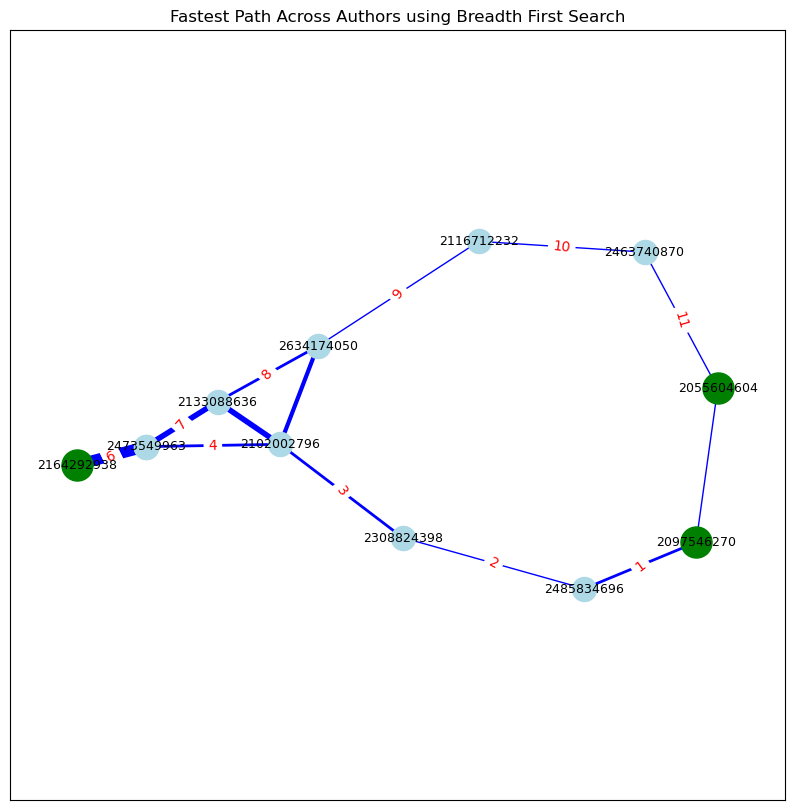

The shortest path between these authors is the following papers:

+------------+----------------------------------------------------------------------------------+
|  Paper ID  |                                      Titles                                      |
+------------+----------------------------------------------------------------------------------+
| 2950178297 |   Show, Attend and Tell: Neural Image Caption Generation with Visual Attention   |
| 2384495648 |   Theano: A Python framework for fast computation of mathematical expressions    |
| 2097117768 |                          Going deeper with convolutions                          |
| 2155893237 |           Caffe: Convolutional Architecture for Fast Feature Embedding           |
| 2613718673 |  Faster R-CNN: towards real-time object detection with region proposal networks  |
| 2613718673 |  Faster R-CNN: towards real-time object detection with region proposal networks  |
| 2102605133 | Rich Feature Hierarchies for Accurate

In [28]:
length= funct_3([2097546270,2164292938,2055604604], 20000)

#### ChatGPT implementation

**Given prompt:**\
Given a NetworkX graph of authors as nodes, connected by edges if they have collaborated together. The graph is weighted and undirected.
Taking collaboration_graph as graph name, given a sequence of authors, find the fastest path that crosses all authors in order, and implement this with python. Write the algorithm yourself, don't use built-in algorithms.

**Analysis:**\
ChatGPT gave me dijkstra's algorithm as a solution to this problem. This is a known algorithm for finding shortest path search in weighted graphs. It works as we can see below, but the solution it gave was 9 steps away and ours was 8. The algorithm it provided might have a lower overall weight, but considering that our weights only represent the number of works in common and not distance, this is not ideal. For visualization, i added a code block to it's code which gives us a plot and the papers to follow.

Our shortest path using Dijkstra's algorithm is [331124168, 2889793201, 2969484184, 2018227268, 2167218018, 2137015694, 2080847109, 2160671624, 2470140333] of length 9.


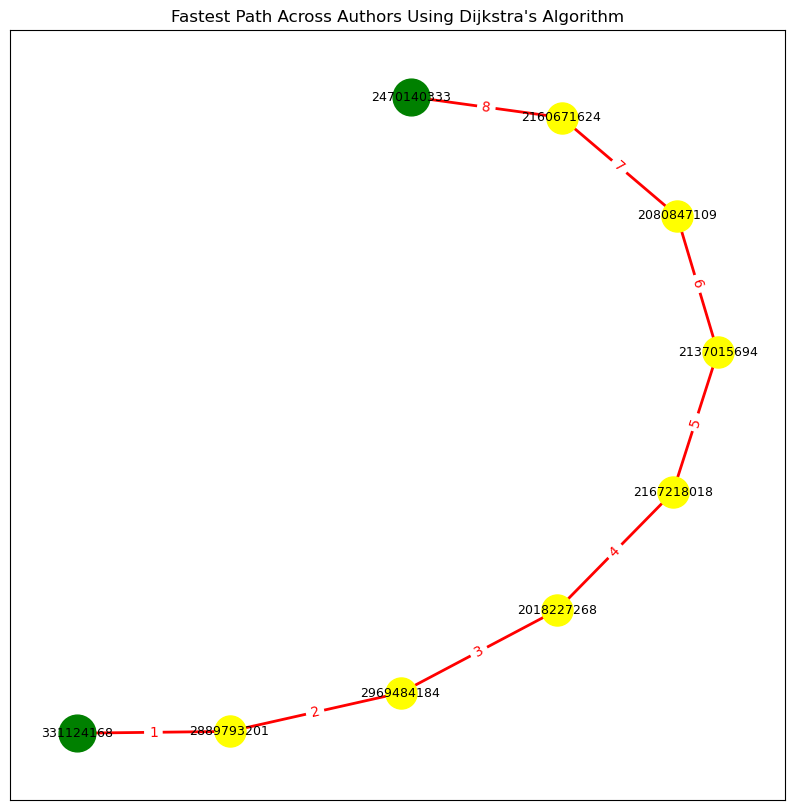

The path to take between these authors is the following papers:

+------------+------------------------------------------------------------------------------------+
|  Paper ID  |                                       Titles                                       |
+------------+------------------------------------------------------------------------------------+
| 1673923490 |                      Intriguing properties of neural networks                      |
| 1591801644 |                      Recurrent Neural Network Regularization                       |
| 2950220847 |           Understanding deep learning requires rethinking generalization           |
| 2951781666 |    HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent     |
| 2126607811 |                  Sparse Reconstruction by Separable Approximation                  |
| 2137628444 | Compressed Channel Sensing: A New Approach to Estimating Sparse Multipath Channels |
| 2195693430 |    An Overview of Si

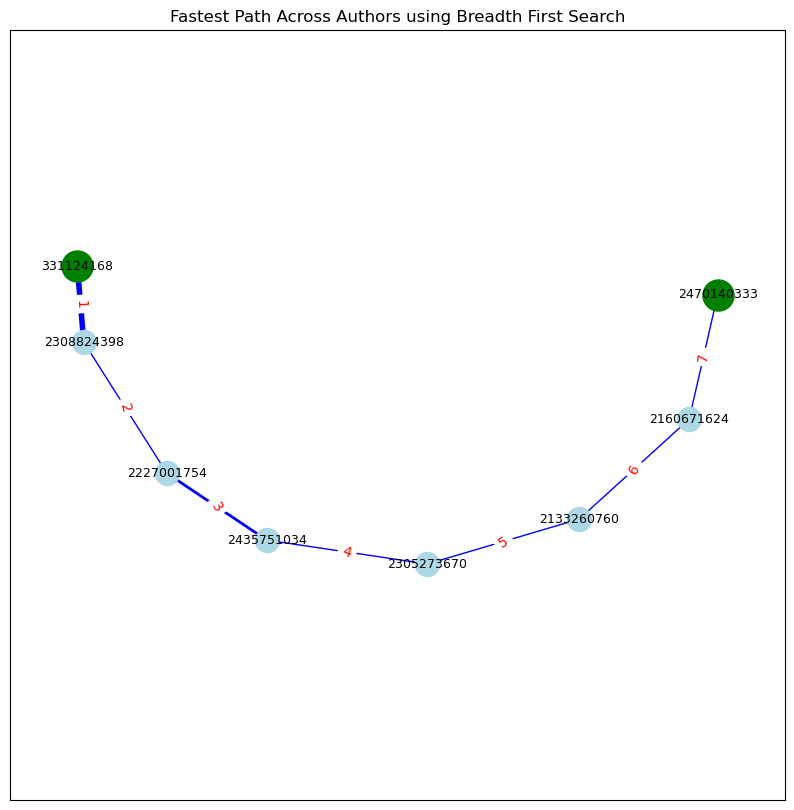

The shortest path between these authors is the following papers:

+------------+----------------------------------------------------------------------------------------+
|  Paper ID  |                                         Titles                                         |
+------------+----------------------------------------------------------------------------------------+
| 2097117768 |                             Going deeper with convolutions                             |
| 2384495648 |      Theano: A Python framework for fast computation of mathematical expressions       |
| 2949608212 |                            Trust Region Policy Optimization                            |
| 2164522996 |                    Kalman filtering with intermittent observations                     |
| 2145873277 | Stochastic geometry and random graphs for the analysis and design of wireless networks |
| 2109159967 |                         Femtocells: Past, Present, and Future                          

In [29]:
import heapq

def dijkstra(graph, start, end):
    """""""""""""""""""""""""""""""""""""""
    Dijkstra's algorithm for finding 
    the shortest path in a weighted graph.
    """""""""""""""""""""""""""""""""""""""
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    priority_queue = [(0, start)]
    path = {start: None}

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_node == end:
            break

        for neighbor in graph.neighbors(current_node):
            # Use the weight of the edge if specified, otherwise default to 1
            weight = graph[current_node][neighbor].get('weight', 1)
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                path[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    # Reconstruct the shortest path
    shortest_path = []
    while end is not None:
        shortest_path.append(end)
        end = path[end]
    return shortest_path[::-1]
    
def find_fastest_path(collaboration_graph, author_sequence):
    """""""""""""""""""""""""""""""""""""""""""""""
    Find the fastest path that crosses all 
    authors in the given sequence and plot it.
    """""""""""""""""""""""""""""""""""""""""""""""
    total_path = []
    for i in range(len(author_sequence) - 1):
        start_author = author_sequence[i]
        end_author = author_sequence[i + 1]

        # Get shortest path for each pair of authors
        path = dijkstra(collaboration_graph, start_author, end_author)

        # Avoid duplication of nodes in the concatenated path
        if total_path and path:
            total_path.extend(path[1:])
        else:
            total_path.extend(path)
    
    print(f"Our shortest path using Dijkstra's algorithm is {total_path} of length {len(total_path)}.")

    # Create a figure for plotting
    plt.figure(figsize=(10, 10))
    cut_subgraph = nx.subgraph(collaboration_graph,total_path)
    labels = nx.get_edge_attributes(cut_subgraph,'weight')
    pos = nx.spring_layout(cut_subgraph)

    # Draw the start and end nodes of the entire sequence
    nx.draw_networkx_nodes(cut_subgraph, pos, nodelist=total_path, node_color='yellow', node_size=500)
    path_edges = list(zip(total_path, total_path[1:]))
    path_order = {t: i+1 for i, t in enumerate(path_edges)}

    nx.draw_networkx_edges(cut_subgraph, pos, edgelist=labels.keys(), edge_color='red', width=2)
    nx.draw_networkx_edge_labels(cut_subgraph,pos,edge_labels=path_order,font_size=10,font_color='r') #we then use the path_order defined above as edge_label
    nx.draw_networkx_labels(cut_subgraph, pos, font_size=9)
    nx.draw_networkx_nodes(cut_subgraph, pos, nodelist=[author_sequence[0], author_sequence[-1]], node_color='green', node_size=700)

    # Final plot adjustments and display
    plt.title("Fastest Path Across Authors Using Dijkstra's Algorithm")
    plt.show()
        
    idtable = PrettyTable()

    papers = []
    for i in range(len(total_path)-1):
        papers.append(collaboration_graph.get_edge_data(total_path[i], total_path[i+1])["paper_ids"][0])

    titles = []
    for paper in papers:
        titles.append(first_10k_rows[first_10k_rows["id"] == paper]["title"].values[0])   


    print("The path to take between these authors is the following papers:")    
    print("")
    idtable.add_column("Paper ID",papers)
    idtable.add_column("Titles",titles)

    print(idtable) 

    return total_path, len(total_path)
    
find_fastest_path(collaboration_graph,[331124168,2470140333])
funct_3([331124168,2470140333], 21179)


_____
### Functionality 4 - Disconnecting Graphs
**Input**:

- The graph data
- authorA: a paper to which will relate sub-graph G_a
- authorB: a paper to which will relate sub-graph G_b
- N: denoting the top N authors that their data should be considered

**Output**:

- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

This problem is a min-cut problem, which is defined as "A Minimum Cut is a a way to partition a (weighted) graph into two disjoint graphs (a cut) so that the edges connecting these two graphs are of minimal weight in summation."

One approach to solving this problem is taking our weighted undirected graph, as a weighted flow graph with each edge having two directions of admissable flow. Author A will be our starting **_Source_** node and author B will be our ending **_Sink_** node. The weight of each edge represents it's Flow **_Capacity_**. The Max-Flow Min-Cut theorem states that the Maximum capacity of Flow we can achieve in our graph between two nodes, is equal to the Minimum weight of cuts needed to disconnect the two nodes. 

Our approach was the following:

- First, create a function **create_residual_graph()** that takes in as input our original graph, initializes a residual graph, an identical copy, but has flow and capacity (equal to edge weight) as it's edge attributes. We wil use this graph to constantly update our flow and capacity.

- Second, we create a function **Edmonds_bfs()** which, given two authors and a graph, implements a breadth first search similar to what we implemented above, but it also checks for whether the edge it is attempting to cross has capacity > 0:

- Next, we implement the **Edmonds-Karp Algorithm** with the function **Edmonds_karp()**, this function iteratively implements **Edmonds_bfs()**, retrieves the path the function returned, finds the edge with the lowest capacity **C** as the path's **path_flow**, and then using **Update_residual_path()**, updates the flow of those path edges on the residual network by **+C** and their capacity by **-C**. The iterations ends when we can no longer find a path from source to sink. 

- By doing this iteratively, edges will start having their capacity drop to 0. Our **Edmonds_bfs()** will find the next shortest path, which will get updated, until no valid paths are available anymore. At each iteration, we add the **path_flow** of the paths we get to get the **Max_flow** of our network.

- Now using the Max-Flow Min-Cut theorem, we implement a new breadth first search on our finalized residual graph using **Bfs_for_cutting()** that tells us which nodes are still reachable from either the source only or the sink only, and which nodes are unreachable (taking edge capacities into account). Knowing that we have maxed out all the capacities that we can and the graph is at maximum flow, all pairs of nodes (U,V) that have an edge between them and only one node can be reached from either the source or the sink are edges we should cut to split the graph into two subgraphs. 

- The approach above leads to redundancies for the cut_set, for example if we have edges (Source, Node_A) and (Node_A, Sink) it is sufficient to cut only one of them. To do this we check whether the source or the sink has more cut_set edges exiting it, and whichever has less will have it's edges removed. 

This was a difficult algorithm to implement, YouTube helped a lot in understanding it how its supposed to work.

In [35]:

def create_residual_graph(graph):              
    """""""""""""""""""""""""""""""""""""""""""""""
    This function creates a copy of our graph called the residual
    graph, with flow and capacity as attributes for the edges. 
    """""""""""""""""""""""""""""""""""""""""""""""
    residual_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        residual_graph.add_edge(u, v, capacity=data['capacity'], flow=0)
    return residual_graph

def update_residual_graph(residual_graph, path, flow):
    """""""""""""""""""""""""""""""""""""""""""""""
    This function updates a given path on the residual  
    graph with values of flow that we give it.
    """""""""""""""""""""""""""""""""""""""""""""""
    for i in range(len(path) - 1):                                      
        u, v = path[i], path[i + 1]
        residual_graph[u][v]['flow'] += flow
        residual_graph[u][v]['capacity'] -= flow
    return residual_graph    

def edomonds_bfs(source, sink, graph):
    """""""""""""""""""""""""""""""""""""""""""""""
    This function implements a breadth first search
    while also checking if an edge's capacity is >0.
    """""""""""""""""""""""""""""""""""""""""""""""
    if source == sink:
        return [source]

    visited = set()                                                                                         # To keep track of seen nodes
    queue = deque([(source, [source])])                                                                     # Initialize our queue for the search

    while queue:
        current_node, path = queue.popleft()

        if current_node == sink:                                                                            # End our search if we reach the end point
            return path  

        for neighbor in graph.neighbors(current_node):                                                      # Search for neighbors for each node
            if neighbor not in visited and graph[current_node][neighbor]['capacity'] > 0:
                visited.add(neighbor)  
                queue.append((neighbor, path + [neighbor]))                                                 # Add to queue unseen nodes with their path
    return False

def bfs_for_cutting(source, graph):     
    """""""""""""""""""""""""""""""""""""""""""""""
    This function implements a breadth first search
    with the goal of checking which nodes are reachable.
    """""""""""""""""""""""""""""""""""""""""""""""
    visited = set()
    queue = deque([source])

    while queue:
        current_node = queue.popleft()
        visited.add(current_node)

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited and graph[current_node][neighbor]['capacity'] > 0:
                queue.append(neighbor)

    return visited

def edmonds_karp(graph, source, sink):
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    This function iteratively implements our edmonds_bfs
    function between the source and sink nodes, updating 
    the flow of the returned path pn the residual graph 
    each time with the highest path_flow possible for it.
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    rGraph = create_residual_graph(graph)
    max_flow = 0

    while True:                                                                         
        path = edomonds_bfs(source, sink, rGraph)
        if not path:
            break

        path_flow = float('inf')
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            path_flow = min(path_flow, rGraph[u][v]['capacity'])

        rGraph= update_residual_graph(rGraph, path, path_flow)
        max_flow += path_flow
    return max_flow, rGraph

def check_path_after_min_cut(graph, source, sink):
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    This function checks if we min_cut successfully by trying
    to find a path using nx.shortest_path after applying cuts.
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    try:
        # try to find the shortest path in the modified graph
        path = nx.shortest_path(graph, source, sink)
        print("Path found:", path)
        return True
    except nx.NetworkXNoPath:
        print(" Checking using Nx.shortest_path, No path exists between the source and sink. Cut correctly applied.")
        return False

def min_cut(graph, source, sink, N):
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    This function combines everything we have defined above,
    first verifying that our inputs are correct, then applying
    edmonds_karp() on our smaller top N graph, then building 
    our cut_set, then applying the cuts and verifying that
    they were applied correctly.
    """""""""""""""""""""""""""""""""""""""""""""""""""""
    assert N <= 21179, ("Please remember that there are 21179 nodes in total. N must be less than or equal.")

    top_N_authors = {node: sum(data["weight"] for _, _, data in graph.edges(node, data=True)) for node in graph.nodes()}
    top_N_authors = sorted(top_N_authors.items(), key=lambda x: x[1], reverse=True)
    top_N_authors = [x for x in top_N_authors if x[1] >= top_N_authors[N][1]]
    top_N_author_ids = [author_id for author_id, _ in top_N_authors]

    if (source or sink) not in top_N_author_ids:
        raise AssertionError(f"Source or sink not in top {N} authors by collaborations.")
    
    # Create a modifiable copy of the smaller_graph
    smaller_graph = graph.subgraph(top_N_author_ids).copy()

    # Apply edmonds karp to our top N graph
    max_flow, rGraph = edmonds_karp(smaller_graph, source, sink)

    # Now we define our cut_set, see markdown for more info
    visited = bfs_for_cutting(source, rGraph)
    visited2 = bfs_for_cutting(sink, rGraph)
    cut_set = []
    
    for u, v in smaller_graph.edges():
        if ((u in visited and v not in visited) or (u not in visited2 and v in visited2)):
            cut_set.append((u, v))

    cut_set_filter =[]
    sink_count = 0
    source_count = 0
    sink_count = sum(sink in edge and source not in edge for edge in cut_set)
    source_count = sum(source in edge and sink not in edge for edge in cut_set)

    if sink_count >= source_count:
        cut_set = [edge for edge in cut_set if not (source in edge and sink not in edge)]
    else:
        cut_set = [edge for edge in cut_set if not (sink in edge and source not in edge)]       


    print(f"Our minimum calculated cut weight is {max_flow}. The minimum cut weight if calculated
           using nx.minimum_cut_value is {nx.minimum_cut_value(smaller_graph, source, sink)}.")
    
    print(f"The first 5 out of {len(cut_set)} edges to cut are {cut_set[:5]}")

    cut_set_weight_sum = sum(graph.get_edge_data(u, v)['weight'] for u, v in cut_set)
    
    print(f"Sum of weights of edges in the cut set: {cut_set_weight_sum}")

    #  Frontend visualization
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # Creates a 2x2 grid of subplots

    pos = nx.spring_layout(smaller_graph, k=0.5)

    # Original graph
    axs[0, 0].set_title('Original Graph', fontsize=15)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[0, 0], node_size=10, node_color='lightblue')
    nx.draw_networkx_edges(smaller_graph, pos, ax=axs[0, 0], width=0.1)

    # Graph with highlighted nodes (green) and cut edges (red)
    axs[0, 1].set_title('Graph with highlighted nodes (green) and cut edges (red)', fontsize=15)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[0, 1], nodelist=[source, sink], node_color="green", node_size=500)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[0, 1], node_size=10, node_color='lightblue')
    nx.draw_networkx_edges(smaller_graph, pos, ax=axs[0, 1], edgelist=cut_set, edge_color='red', width=2)
    nx.draw_networkx_edges(smaller_graph, pos, ax=axs[0, 1], width=0.1)

    # Magnified and numbered version of the cut edges
    axs[1, 0].set_title('Magnified and numbered version of the cut edges', fontsize=15)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[1, 0], nodelist=[source, sink], node_color="green", node_size=500)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[1, 0], node_size=10, node_color='lightblue')
    nx.draw_networkx_edges(smaller_graph, pos, ax=axs[1, 0], edgelist=cut_set, edge_color='red', width=2)
    path_order = {t: i+1 for i, t in enumerate(cut_set)}
    nx.draw_networkx_edge_labels(smaller_graph, pos, ax=axs[1, 0], edge_labels=path_order, font_size=12, font_color='r')

    # Final graph (after removing links)
    axs[1, 1].set_title('Final Graph (after removing links)', fontsize=15)
    smaller_graph.remove_edges_from(cut_set)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[1, 1], nodelist=[source, sink], node_color="green", node_size=500)
    nx.draw_networkx_nodes(smaller_graph, pos, ax=axs[1, 1], node_size=10, node_color='lightblue')
    nx.draw_networkx_edges(smaller_graph, pos, ax=axs[1, 1], width=0.1)

    plt.tight_layout()
    plt.show()
    
    # Verify that min_cut is correctly applied
    check_path_after_min_cut(smaller_graph, source,sink)
    
    return cut_set, max_flow, rGraph, smaller_graph

Our minimum calculated cut weight is 94. The minimum cut weight if calculated using nx.minimum_cut_value is 94.
The first 5 out of 94 edges to cut are [(696648706, 1772069374), (2231850505, 1772069374), (2189829644, 1772069374), (2920985617, 1772069374), (257558059, 1772069374)]
Sum of weights of edges in the cut set: 94


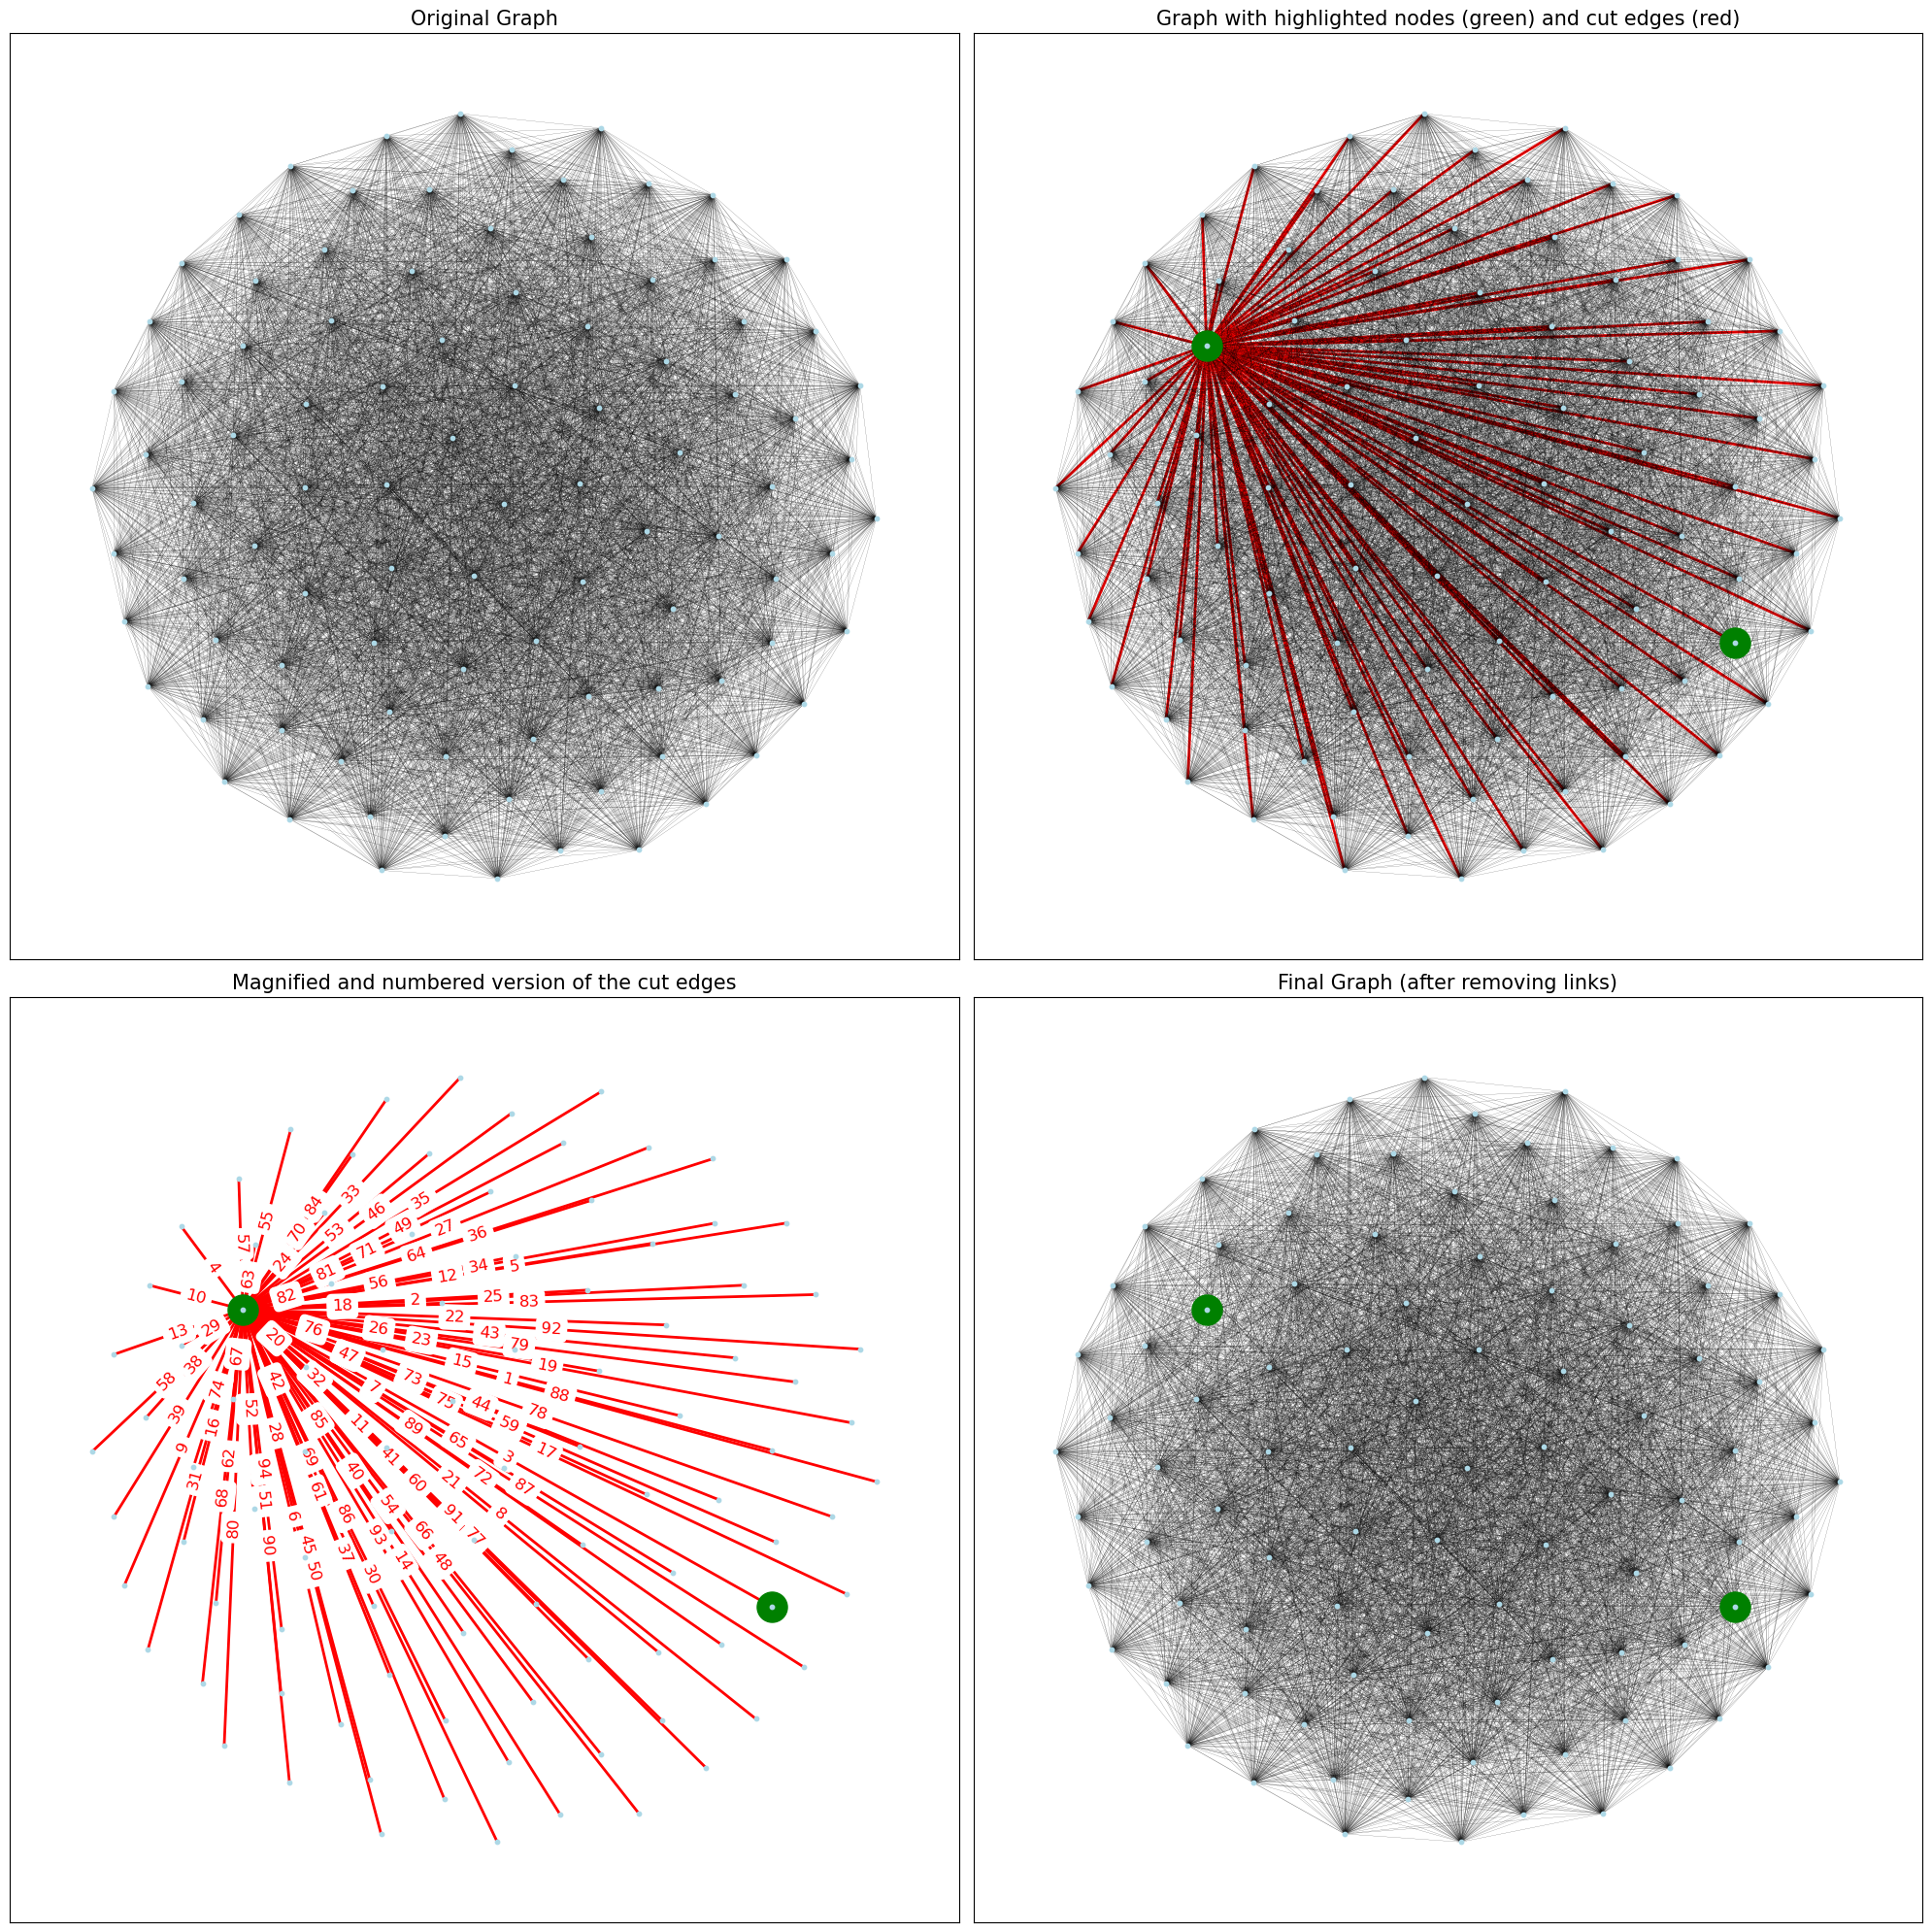

 Checking using Nx.shortest_path, No path exists between the source and sink. Cut correctly applied.


In [36]:
small = create_collaboration_graph(first_10k_rows[750:900])
cuts, max_flo, residual, smaller_graph = min_cut(small,2189829644, 1772069374, 25)

_____
### Functionality 5 - Extracting Communities

**Input**: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

**Output**:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

For this part i relied on the NetworkX documentation so that i could understand how to implement the algorithm.<br>
In this section the Girvan-Newman algorithm will be implemented, by following these steps:<br>

**First part**:
- Compute the edge betweenness (EB) given the citation graph as input (without rescaling as you will notice).<br>
Edge betweenness is a measure of the number of shortest
paths the edge is part of: sum of the fraction of the shortest paths going
through the edge between any two nodes.

(From the https://networkx.org/documentation/stable/index.html)<br>

$$c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$$

where $V$ is the set of nodes, $\sigma(s, t)$ is the number of
shortest $(s, t)$-paths,  and $\sigma(s, t|v)$ is the number of
those paths  passing through some  node $v$ other than $s, t$.
If $s = t$, $\sigma(s, t) = 1$, and if $v \in {s, t}$,
$\sigma(s, t|v) = 0$.

**Second part**:
- Compute the original number of connected components (CC) as a baseline. The list of CC will be our communities, since by definition those are subgraphs of the original graph, without any edges connected to other "communities/CC"
    - While the number of components is less then the updated number of CC, compute the EB, sort it by the highest value and remove the edge associated with it.
    - The loop will stop if the number of new communities (total CC) is higher than before.
- At the end this will give us the list of communities, namely a list of paper that belongs to the same "universe"


In [19]:
def SP_BFS(G, s): #another implementation of BFS, but with a single node as input, compared to the one in the other section
    S = [] #list of the nodes visited
    P = {} #predecessor of the node 
    for v in G:
        P[v] = []
    sigma = dict.fromkeys(G, 0.0)  # sigma[v]=0 for v in G
    D = {}
    sigma[s] = 1.0
    D[s] = 0
    Q = deque([s])
    while Q:  # use BFS to find shortest paths
        v = Q.popleft()
        S.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                Q.append(w)
                D[w] = Dv + 1
            if D[w] == Dv + 1:  # this is a shortest path, count paths
                sigma[w] += sigmav
                P[w].append(v)  # predecessors
    return S, P, sigma, D


def edges_weights(betweenness, S, P, sigma, s):  #it iterates over the nodes in the graph in reverse order of their distance from the source node
    delta = dict.fromkeys(S, 0)
    while S:
        w = S.pop()
        coeff = (1 + delta[w]) / sigma[w] 
        for v in P[w]:
            c = sigma[v] * coeff
            if (v, w) not in betweenness:
                betweenness[(w, v)] += c
            else:
                betweenness[(v, w)] += c
            delta[v] += c
        if w != s:
            betweenness[w] += delta[w]
    return betweenness


def edge_betweenness(graph): #compute the edge_betweenness
    betweenness = dict.fromkeys(graph, 0.0)  # b[v]=0 for v in G
    # b[e]=0 for e in G.edges()
    betweenness.update(dict.fromkeys(graph.edges(), 0.0))
    for s in graph:
        S, P, sigma, _ = SP_BFS(graph, s)
        betweenness = edges_weights(betweenness, S, P, sigma, s)
    for n in graph:  # remove nodes to only return edges
        del betweenness[n] 
    return betweenness



Why using connected components (CC) and not weakly connected components (WCC) or strongly connected components (SCC)?<br>
We can talk about WCC or SCC only in the directed graph case, since they have the two following definitions:
 - A strongly connected component is the component of a directed graph that has a path from every vertex to every other vertex in that component.
 - A weakly connected component is a subgraph that is unreachable from other nodes/vertices of a graph or subgraph, and it only requires nodes to be reachable in one direction.

For this part the graph is converted to an undirected type graph, since the Girvan-Newman algorithm works on this type of graphs. We lose the unidirectionality of the directed graph, but we still have all the egde_centrality information from the last iteration.<br>


In [20]:
def connected_components(G): #Use BFS for finding the connected components. DFS was an alternative but both algorithms can be used, based on what i've found researching oline
    seen = set()
    for v in G:
        if v not in seen:
            c,_,_,_ = SP_BFS(G, v)
            seen.update(c)
            yield c

def number_connected_components(G):
    return sum(1 for cc in connected_components(G))

def check_community(lst, elem1, elem2): #check if in the same community
    return any(elem1 in sublist and elem2 in sublist for sublist in lst)

In [21]:
def funct_5(graph,N,paper1,paper2):

    graph = create_citations_graph(first_10k_rows[:N]) #Top N papers
    assert paper1 in first_10k_rows[:N]["id"].values, f"{paper1} is not in the top {N} papers."
    assert paper2 in first_10k_rows[:N]["id"].values, f"{paper2} is not in the top {N} papers."
    graph = graph.to_undirected()
    original_num_components = number_connected_components(graph) #initial number of connected components
    num_new_components = original_num_components  
    print(f"Original number of connected components is {num_new_components}.")

    n_count = 0
    cut_list =[]
    while num_new_components <= original_num_components: #we stop if the number of communities increases after cutting a graph edge
        test = edge_betweenness(graph) #iteratively compute the edge_betweenness
        edge_to_remove = sorted(test.items(), key=lambda x: -x[1])[0][0] #sort and remove the edge with the highest value
        graph.remove_edge(*edge_to_remove)
        cut_list.append(edge_to_remove)
        n_count +=1 #counter for edge removed
        new_components = list(connected_components(graph))
        num_new_components = len(new_components)

    print(f"The minimum number of edges to remove is {n_count}. The edges to remove are {cut_list}.")

    if check_community(new_components, paper1, paper2):
        print(f"Papers ({paper1}, {paper2}) are in the same community.")
    else:
        print(f"{paper1} and {paper2} are not in the same community.")

    # frontend visualization
    sorted_communities = sorted(new_components, key=len, reverse=True)    
    community_df = pd.DataFrame({'Community': range(1, len(sorted_communities) + 1),
                                 'Size': [len(comm) for comm in sorted_communities],
                                 'Members': sorted_communities})

    # Display communities
    print("The top 10 communities sorted from largest to smallest:")
    print(community_df.head(10))

    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    pos = nx.spring_layout(graph, k=1)

    # Original graph
    axs[ 0].set_title('Original Graph')
    nx.draw_networkx_nodes(graph, pos, ax=axs[ 0], node_size=50, node_color='lightblue')
    nx.draw_networkx_edges(graph, pos, ax=axs[ 0])
    nx.draw_networkx_labels(graph, pos, ax=axs[ 0], font_size=6)

    # Graph with edges to cut
    axs[1].set_title('Graph with Edges to Cut')
    nx.draw_networkx_nodes(graph, pos, ax=axs[ 1], node_size=50, node_color='orange')
    nx.draw_networkx_edges(graph, pos, ax=axs[ 1])
    nx.draw_networkx_edges(graph, pos, ax=axs[ 1], edgelist=cut_list, edge_color='red', width=2)
    nx.draw_networkx_labels(graph, pos, ax=axs[1], font_size=6)

    # Graph with different communities color coded, our papers are larger in size
    axs[ 2].set_title('Graph with Communities')

    community_colors = itertools.cycle(mcolors.TABLEAU_COLORS)
    color_map = {i: next(community_colors) for i, _ in enumerate(new_components)}
    node_colors = [color_map[i] for node in graph.nodes() for i, comp in enumerate(new_components) if node in comp]

    special_nodes = [paper1, paper2]
    node_sizes = [250 if node in special_nodes else 50 for node in graph.nodes()]
    
    nx.draw_networkx_nodes(graph, pos, ax=axs[2], node_size=node_sizes, node_color=node_colors)    
    nx.draw_networkx_edges(graph, pos, ax=axs[ 2])
    nx.draw_networkx_labels(graph, pos, ax=axs[ 2], font_size=6)

    plt.tight_layout()
    plt.show()



Original number of connected components is 37.
The minimum number of edges to remove is 1. The edges to remove are [(2153635508, 2119821739)].
Papers (2119821739, 2139212933) are in the same community.
The top 10 communities sorted from largest to smallest:
   Community  Size                               Members
0          1     3  [1639032689, 2121863487, 1595159159]
1          2     3  [2156909104, 2139212933, 2119821739]
2          3     2              [2151103935, 2161969291]
3          4     2              [2911964244, 2163605009]
4          5     2              [2153635508, 2133990480]
5          6     2              [1791587663, 2100379340]
6          7     2              [2103441770, 2108234281]
7          8     2              [2146058063, 2161444534]
8          9     2              [2132984323, 1667165204]
9         10     2              [2064675550, 2194775991]


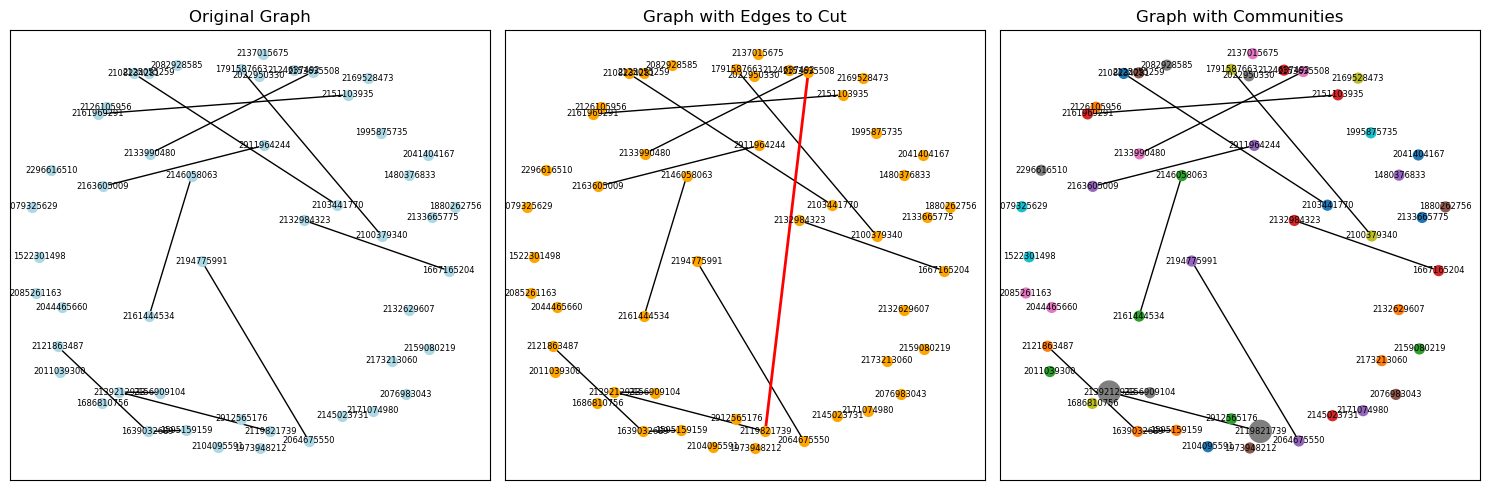

Original number of connected components is 46.
The minimum number of edges to remove is 1. The edges to remove are [(2153635508, 2119821739)].
2119821739 and 2153635508 are not in the same community.
The top 10 communities sorted from largest to smallest:
   Community  Size                               Members
0          1     3  [1639032689, 2121863487, 1595159159]
1          2     3  [2911964244, 2912934387, 2163605009]
2          3     3  [2153635508, 2133990480, 2101234009]
3          4     3  [2156909104, 2139212933, 2119821739]
4          5     3  [2124637492, 2148606196, 2066636486]
5          6     3  [2166559705, 2149706766, 2137401668]
6          7     2              [2151103935, 2161969291]
7          8     2              [1791587663, 2100379340]
8          9     2              [2103441770, 2108234281]
9         10     2              [2146058063, 2161444534]


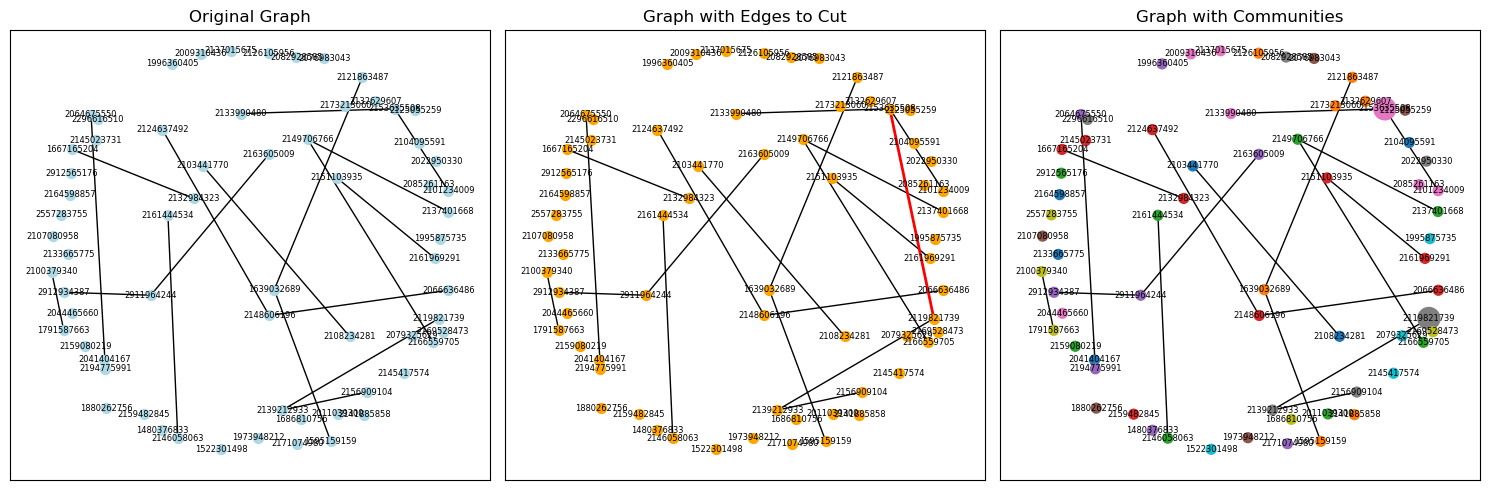

In [22]:
funct_5(citation_graph,50,2119821739,2139212933)
funct_5(citation_graph,65,2119821739,2153635508)

_____
### Visualization with interactive display

We will implement an interactive GUI for our functionalities, that allows users to select what function to implement and with what input parameters.

In [33]:
# Dropdown menu with 5 options for 5 functionalities
func_dropdown = widgets.Dropdown(
    options=[('Functionality 1', 1), ('Functionality 2', 2),
             ('Functionality 3', 3), ('Functionality 4', 4),
             ('Functionality 5', 5)],description='Function:')

# Dropdown menu for selecting the graph type incase func 1 or 2 is selected above
graph_dropdown = widgets.Dropdown( options=[('Citation Graph', 'citation'), ('Collaboration Graph', 'collaboration')], description='Graph:')

# Input tab for input nodes for func 3, 4, and 5
node_input = widgets.Text(description='Node/Sequence:')

# Input for N for 3, 4, and 5
n_input = widgets.IntText(description='N:')

# Button to execute the request
execute_button = widgets.Button(description='Execute')

# Section to display output
output = widgets.Output()

# Container for dynamic widgets to clear output after changing functionality 
dynamic_widgets = widgets.VBox([])

# We implement a function to handle what happens when the execute button is clicked
def on_execute_button_clicked(b):
    
    with output:
        clear_output()
        try:
            func_value = func_dropdown.value
            graph = citation_graph if graph_dropdown.value == 'citation' else collaboration_graph
            nodes = node_input.value.split(',')
            nodes = [int(x) for x in nodes]
            
            if func_value == 1:
                funct_1(graph, graph_dropdown.label)
            elif func_value == 2:
                funct_2(graph, int(node_input.value), graph_dropdown.label)
            elif func_value == 3:
                funct_3(nodes, n_input.value)
            elif func_value == 4:
                if len(nodes) >= 2:
                    min_cut(small,nodes[0],nodes[1], n_input.value)
            elif func_value == 5:
                if len(nodes) >= 2:
                    funct_5(citation_graph, n_input.value,nodes[0],nodes[1])

        except Exception as e:
            print(f"An error occurred: {e}")

# We tell our GUI to implement the on_execute_button_clicked function when the button is pressed
execute_button.on_click(on_execute_button_clicked)

# We implement a function to update the dynamic output window with widgets depending on what functionality is chosen
def update_dynamic_widgets(func_value):
    dynamic_widgets.children = []
    if func_value in [1, 2]:
        widgets_to_display = [graph_dropdown]
        if func_value == 2:
            widgets_to_display.append(node_input)

    elif func_value in [3, 4, 5]:
        widgets_to_display = [node_input, n_input]
    
    dynamic_widgets.children = widgets_to_display + [execute_button, output]

# We implement a function to update the output window incase we notice a change in the functionality dropdown choice
def on_function_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_dynamic_widgets(change['new'])

# We tell the GUI to respond to changes in the dropdown selection by calling the On_function_change function
func_dropdown.observe(on_function_change)

display(func_dropdown, dynamic_widgets)


Dropdown(description='Function:', options=(('Functionality 1', 1), ('Functionality 2', 2), ('Functionality 3',…

VBox()

_____
## 3. Algorithmic Questions (AQ)

### Part A

##### 1. Implement an algorithm to solve the described mentioned problem.

To solve this problem, we decided to implement the Depth-First Search (DFS) algorithm. Depth-First Search (DFS) is a graph traversal algorithm which starts at a selected node and explores as far as possible along each branch before backtracking.

In [ ]:
list_of_dicts = []
N, M, S = map(int, input("Enter N, M and S: ").split())
req_skills = input("Please input the desired skills: ").split()
for i in range(N):
    nu = int(input("Enter athlete number: "))
    if nu == i+1:
        athlete_dict = {}
        for j in range(0,S):
            skill, level = input(f"Please enter skill {j+1} and level of athlete {i+1}: ").split()
            athlete_dict[skill] = int(level)
        list_of_dicts.append(athlete_dict)

converted_dict = {}
for index, dictionary in enumerate(list_of_dicts, start=1):
    converted_dict[index] = dictionary

In [ ]:
def depfsearch(athlete_dict, list_of_skills, used_athletes, c, score):
    if c == len(list_of_skills):
        return score

    highest_score = 0

    for athlete, skills in athlete_dict.items():
        if athlete not in used_athletes:
            used_athletes.add(athlete)
            skill_score = skills.get(list_of_skills[c], 0) # If the athlete does not have that skill, score=0
            score = depfsearch(athlete_dict, list_of_skills,used_athletes,c + 1,score + skill_score)
            highest_score = max(highest_score, score) # Get the score that is maximum
            used_athletes.remove(athlete) #Eliminate the athlete from used_athletes so that we can check the new skill for this athlete
    return highest_score

In [ ]:
used_athletes = set()
maximum_score = depfsearch(athlete_dict=converted_dict,list_of_skills=req_skills,used_athletes=used_athletes,c=0,score=0)
print(maximum_score)

399


##### 2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

The first part of the code where it takes inputs and creates dictionaries runs in O(N*S) time because it loops over all athletes (N) and for each athlete, it loops over all their skills (S). The second part of the code where it converts the list of dictionaries into a single dictionary also runs in O(N) time because it simply iterates over the list once.

The main part of the code where the DFS algorithm is implemented is the most complex. This part runs in O(N^M) time because for each of the M skills, it potentially checks every one of the N athletes. However, since the algorithm stops as soon as it finds a valid combination of athletes, the actual runtime could be less than this worst-case scenario.

Therefore, the overall time complexity of the code is O(N*S + N + N^M). However, the term with the highest degree (N^M) dominates the other terms for large values of N and M, so we often say that the time complexity is O(N^M).


##### 3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the <ins>two differ</ins>, which one is right? (why?)
#### This is the answer provided by ChatGPT - 

The code consists of two main parts:
1. Input Reading: Reading inputs for athletes' skills, desired skills, athlete numbers, and their corresponding skill levels. This section involves reading N athletes, each having S skills.
2. DFS Function (dfs): This function is the core of the algorithm. It performs a depth-first search to explore all possible combinations of athletes and skills to find the maximum score.

Let's analyze the time complexity of each part:
1. Input Reading: Reading N athletes, each with S skills, involves O(N * S) operations.
2. DFS Function (dfs): 
The DFS function explores all possible combinations of N athletes for M skills.
For each skill, it iterates through all the athletes (N) to find the maximum score.
At each level of recursion, it checks each athlete for the current skill, which results in N iterations.
The function is recursive and explores all combinations of athletes for all skills.

The time complexity of the DFS function can be approximated as follows:
For each skill, there are N athletes to consider. Since there are M skills to be matched, the total number of combinations explored is N^M.
Combining both parts, the overall time complexity of the code is O(N * S + N^M). The dominating factor here is the DFS function, which explores all combinations of athletes for each skill. This results in an exponential time complexity, particularly O(N^M), considering the worst-case scenario where all athletes possess all required skills.

In conclusion, the time complexity we calculated is the same as the one determined by ChatGPT.

##### 4. If you algorithm has exponential time complexity, can you provide a __polynomial-time version__? 
The algorithm we implemented earlier will result in an exponential time complexity, specifically in the worst-case scenarios.

To convert this exponential-time algorithm into a polynomial-time one, we should use dynamic programming techniques to optimize the solution. Dynamic programming can store and reuse intermediate results and hence, avoiding redundant computation, resulting in a reduced time complexity.

In [ ]:
def max_score_dp(athlete_dict, list_of_skills):
    dp = {}  # Create a dictionary to store intermediate results

    def helper(index, skills_left):
        if index == len(athlete_dict):
            return 0

        if (index, skills_left) in dp:
            return dp[(index, skills_left)]

        max_score = 0

        for skill, level in athlete_dict[index + 1].items():
            if skill in skills_left:
                updated_skills = skills_left.copy()
                updated_skills.remove(skill)
                score = level + helper(index + 1, updated_skills)
                max_score = max(max_score, score)

        dp[(index, skills_left)] = max_score
        return max_score

    return helper(0, set(list_of_skills))

list_of_dicts = []
N, M, S = map(int, input("Enter N, M and S: ").split())
req_skills = input("Please input the desired skills: ").split()
for i in range(N):
    nu = int(input("Enter athlete number: "))
    if nu == i + 1:
        athlete_dict = {}
        for j in range(S):
            skill, level = input(f"Please enter skill {j + 1} and level of athlete {i + 1}: ").split()
            athlete_dict[skill] = int(level)
        list_of_dicts.append(athlete_dict)

maximum_score = max_score_dp({i + 1: list_of_dicts[i] for i in range(len(list_of_dicts))}, req_skills)
print(maximum_score)

This revised version uses a dynamic programming approach by maintaining a dp dictionary to store and reuse intermediate results. By doing this, the algorithm avoids recalculating previously solved subproblems, reducing the overall time complexity to a polynomial-time solution, specifically O(N * S * 2^S) in this case. The improvement comes from memoization and not exploring all combinations explicitly.

##### 5. If $S=1$, how does the __time complexity__ of an optimal algorithm to solve this problem change?
The value of `S` is not important as the algorithm is only dependent on the values of N and M.


_____
### Part B

**Tasks**:
1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution ?

**1**. Let's consider our Graph initially assuming that each node interconnects with every other node, presenting two potential scenarios:

A. The two individuals that are familiar with each other, and based on how close/distant they are, will put in low or high effort to work together.

B. Conversely, two unfamiliar individuals may work together, and the collaborative effort depends on their individual tendencies.

Drawing parallels to another problem, think of a scenario where a manager oversees a team comprising various skill sets. The challenge lies in forming an effective team structure while considering individual compatibility and collaboration efforts.

Our problem falls within the NP complexity class, meaning a proposed solution can be swiftly validated to determine its acceptability. This validation involves checking if the athletes possess the requisite skills, with a complexity of O(n). Additionally, assessing the existence of a spanning tree incurs O(n^2) due to our graph structure.

To demonstrate its NP-completeness, we can reference a different problem akin to the one mentioned earlier, perhaps one related to optimizing resource allocation within a network or organizing tasks among team members.

**2**. In order to devise a heuristic algorithm for this challenge:

We may compute the "weight of the node" by evaluating the sum of each edge's weight linked to that node, costing O(n(n-1)), where n signifies the node count.

Saving this information in a sorted list, arranging individuals based on their relative compatibility or collaborative efficiency, can aid in identifying better team dynamics, incurring O(n log n).

Proceeding from the most compatible individual, verifying their possession of required skills, and iteratively exploring similarly compatible nodes reduces to O(n) passages. This ensures that skills are acquired systematically, ensuring optimal team cohesion.

Upon obtaining a refined subgraph for the spanning tree, applying the Kruskal algorithm (with a cost of O(k log k), where k represents the subgraph's edge count) helps determine an effective team structure.

This algorithm, while oriented towards fostering a harmonious team dynamic, might overlook strong intra-group relationships. It focuses on avoiding individuals with particularly detrimental associations, prioritizing general positive team dynamics over singular strong relationships, underlining the significance of cohesive teamwork within smaller groups.

**3**. The algoritmic cost of the previous algorithm is O(n^2+nlog(n))

_____